In [1]:
import torch
from load_data import *
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
device = torch.device('cuda:0')

In [3]:
Xtr, Xte, ytr, yte, Ztr, Zte = load_bank_data(random_state=42)
ytr = ytr.astype('float32').reshape((-1,1))
yte = yte.astype('float32').reshape((-1,1))

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [4]:
print("sensitive ratio: ",sum(Ztr==0)/len(Ztr))
print("training default: ", sum(ytr==0)/len(ytr))
print("test default: ", sum(yte==0)/len(yte))
print('# training samples:', Xtr.shape)
print('# test samples:', Xte.shape)
print('# sensitive vars', Ztr.shape)
print('# output vars', ytr.shape)

sensitive ratio:  [0.39902676]
training default:  [0.88425443]
test default:  [0.88012386]
# training samples: (31647, 45)
# test samples: (13564, 45)
# sensitive vars (31647, 1)
# output vars (31647, 1)


In [5]:
Xrs = np.row_stack([Xtr,Xte])
print(Xrs.shape)
print(np.unique(Xrs,axis=0).shape)

(45211, 45)
(45211, 45)


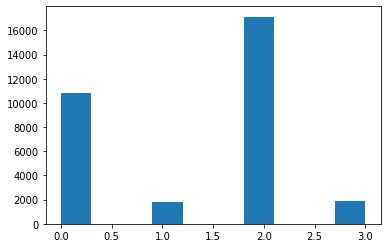

In [6]:
import matplotlib.pyplot as plt
yz_tr = ytr+Ztr*2
plt.hist(yz_tr)
plt.show()

In [7]:
N1 = 10000
Xtr1, ytr1, Ztr1, Xtr2, ytr2, Ztr2 = split_initial_dataset(Xtr,ytr,Ztr,N_init=N1,random_state=42)

In [8]:
print("sensitive ratio: ",sum(Ztr==0)/len(Ztr))
print("training init: ", sum(ytr1==0)/len(ytr1))
print("select init: ", sum(ytr2==0)/len(ytr2))
print("test default: ", sum(yte==0)/len(yte))

sensitive ratio:  [0.39902676]
training init:  [0.8848]
select init:  [0.8840024]
test default:  [0.88012386]


In [9]:
from fairNN_train import *
from load_data import *
from fair_eval import *

In [10]:
class Args:
    def __init__(self):
        self.epochs = 20
#         self.max_epochs = None
        self.AL_iters = 10 # AL batch 몇 번 뽑는지?
        self.AL_batch = 32 # AL 시에 select 되는 데이터 수
        self.batch_size = 64
        self.AL_select = 'acc'
        self.num_classes = 2
#         self.AL_valid = 32
        
    def print_args(self):
        print("train epochs/batch: {}/{}".format(self.epochs,self.batch_size))
        print("AL iters/batch: {}/{}".format(self.AL_iters,self.AL_batch))
        print("AL selection is based on ", self.AL_select)

In [11]:
from fairAL_utils import *

In [12]:
args = Args()
train_data = NPsDataSet(Xtr1, ytr1, Ztr1)
train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True, drop_last=False)
zZtr2 = transform_dum2cat(Ztr2)
select_data = NPsDataSet(Xtr2, ytr2, zZtr2)
select_loader = DataLoader(select_data, batch_size=args.batch_size, shuffle=False, drop_last=False)
test_data = NPsDataSet(Xte, yte, Zte)
test_loader = DataLoader(test_data, batch_size=args.batch_size, shuffle=False, drop_last=False)

In [13]:
n_features = train_data.tensors[0].shape[1]
clf = Classifier(n_features=n_features)
clf.to(device)

Classifier(
  (network): Sequential(
    (0): Linear(in_features=45, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [14]:
clf_criterion = nn.BCELoss()
clf_optimizer = optim.Adam(clf.parameters())
liveloss = PlotLosses()

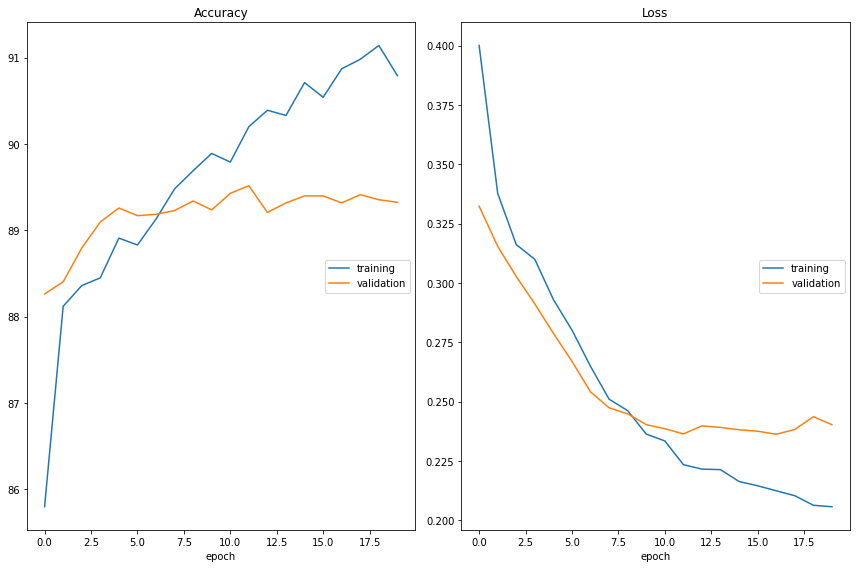

Accuracy
	training         	 (min:   85.800, max:   91.140, cur:   90.790)
	validation       	 (min:   88.263, max:   89.516, cur:   89.325)
Loss
	training         	 (min:    0.206, max:    0.400, cur:    0.206)
	validation       	 (min:    0.236, max:    0.332, cur:    0.240)
Finished Training


In [74]:
train_model(clf, train_loader, clf_criterion,clf_optimizer, device, args.epochs, test_loader,liveloss)
torch.save(clf.state_dict(),"../results/bank/AL_iter_2.ckpt") # 모든 애들을 다 0으로 예측함

In [15]:
clf.load_state_dict(torch.load("../results/bank/AL_iter_2.ckpt"))

<All keys matched successfully>

# Visualize the trained model

In [16]:
clf.eval()
from torchsummary import summary
summary(clf.to('cuda:0'),(45,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]           1,472
              ReLU-2                   [-1, 32]               0
           Dropout-3                   [-1, 32]               0
            Linear-4                   [-1, 32]           1,056
              ReLU-5                   [-1, 32]               0
           Dropout-6                   [-1, 32]               0
            Linear-7                   [-1, 32]           1,056
              ReLU-8                   [-1, 32]               0
           Dropout-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
Total params: 3,617
Trainable params: 3,617
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total

In [17]:
param_names = ['lin1_w','lin1_b','lin2_w, lin2_b','lin3_w','lin3_b','lin4_w','lin4_b']

# instance-level gradient

In [18]:
from viz_utils import *

In [19]:
train_data = NPsDataSet(Xtr1, ytr1, Ztr1)
train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=False, drop_last=False)
zZtr2 = transform_dum2cat(Ztr2)
select_data = NPsDataSet(Xtr2, ytr2, zZtr2)
select_loader = DataLoader(select_data, batch_size=args.batch_size, shuffle=False, drop_last=False)
test_data = NPsDataSet(Xte, yte, Zte)
test_loader = DataLoader(test_data, batch_size=args.batch_size, shuffle=False, drop_last=False)

In [20]:
bn_criterion = BinaryEntropy()

In [21]:
out_tr, y_tr, z_tr, wgrad_tr, grdic_tr = compute_grad_arrs(clf, train_loader, clf_criterion, device, param_names)
out_te, y_te, z_te, wgrad_te, grdic_te = compute_grad_arrs(clf, test_loader, clf_criterion, device, param_names)

In [22]:
out_tr2, y_tr2, z_tr2, wgrad_tr2, grdic_tr2 = compute_predgrad_arrs(clf, train_loader, clf_criterion, device, param_names)
out_te2, y_te2, z_te2, wgrad_te2, grdic_te2 = compute_predgrad_arrs(clf, test_loader, clf_criterion, device, param_names)

In [23]:
out_tr3, y_tr3, z_tr3, wgrad_tr3, grdic_tr3 = compute_predgrad_arrs(clf, train_loader, bn_criterion, device, param_names,True)
out_te3, y_te3, z_te3, wgrad_te3, grdic_te3 = compute_predgrad_arrs(clf, test_loader, bn_criterion, device, param_names,True)

In [24]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=False)
g2_tr = pca.fit_transform(wgrad_tr)
g2_te = pca.transform(wgrad_te)
g2_tr2 = pca.transform(wgrad_tr2)
g2_te2 = pca.transform(wgrad_te2)
g2_tr3 = pca.transform(wgrad_tr3)
g2_te3 = pca.transform(wgrad_te3)

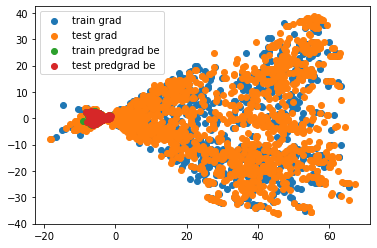

In [25]:
plt.figure()
plt.scatter(g2_tr[:,0],g2_tr[:,1],label='train grad')
plt.scatter(g2_te[:,0],g2_te[:,1],label='test grad')
# plt.scatter(g2_tr2[:,0],g2_tr2[:,1],label='train predgrad')
# plt.scatter(g2_te2[:,0],g2_te2[:,1],label='test predgrad')
plt.scatter(g2_tr3[:,0],g2_tr3[:,1],label='train predgrad be')
plt.scatter(g2_te3[:,0],g2_te3[:,1],label='test predgrad be')

plt.legend()
plt.show()

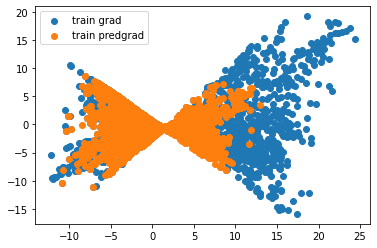

In [37]:
plt.figure()
plt.scatter(g2_tr[:,0],g2_tr[:,1],label='train grad')
# plt.scatter(g2_te[:,0],g2_te[:,1],label='test grad')
plt.scatter(g2_tr2[:,0],g2_tr2[:,1],label='train predgrad')
# plt.scatter(g2_te2[:,0],g2_te2[:,1],label='test predgrad')
plt.legend()
plt.show()

No handles with labels found to put in legend.


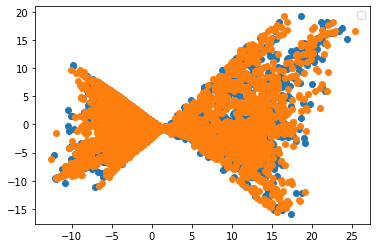

In [38]:
plt.figure()
plt.scatter(g2_tr[:,0],g2_tr[:,1])
plt.scatter(g2_te[:,0],g2_te[:,1])
plt.legend()
plt.show()

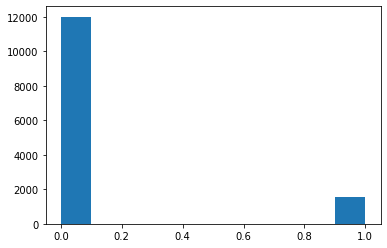

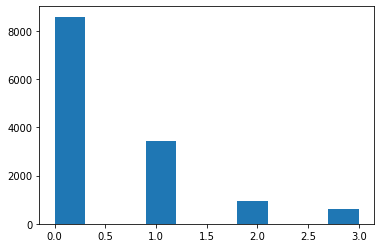

In [84]:
plt.hist(y_tr)
plt.show()
plt.hist(out_tr+2*y_tr)
plt.show()

lywise


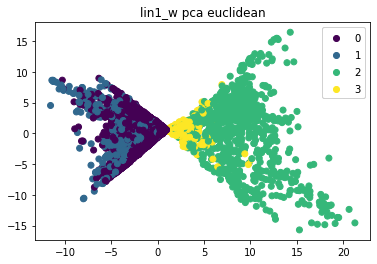

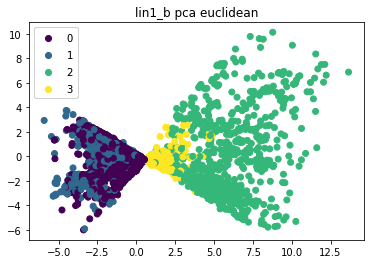

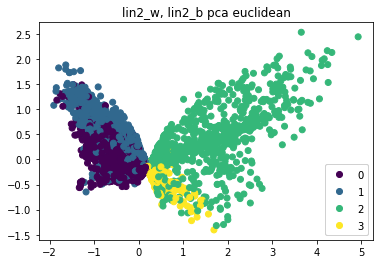

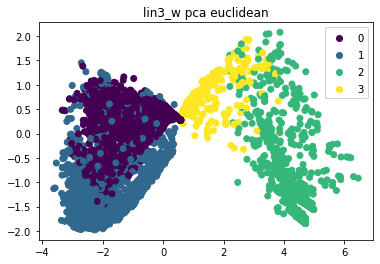

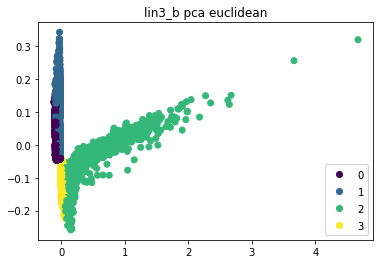

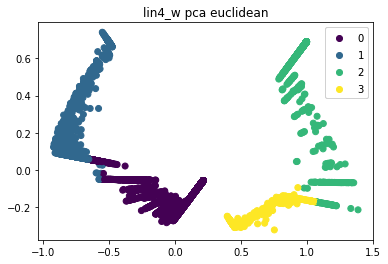

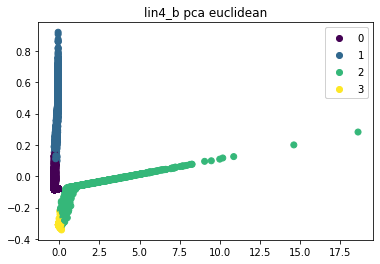

In [42]:
viz_plot_grad(grdic_tr,out_tr+2*y_tr,lywise=True, param_names=param_names)

lywise


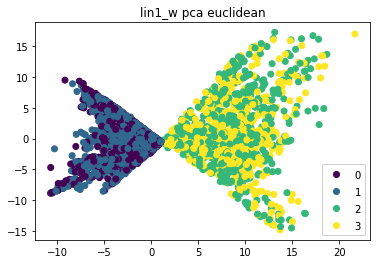

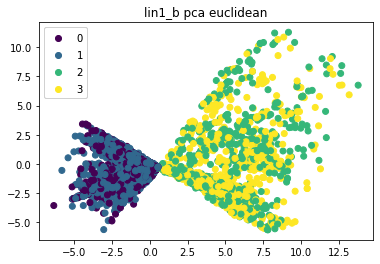

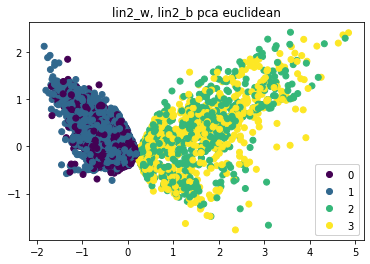

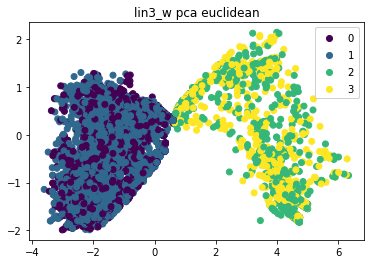

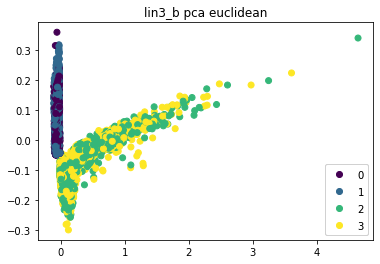

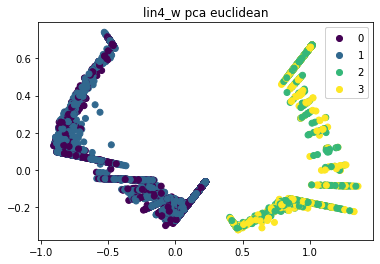

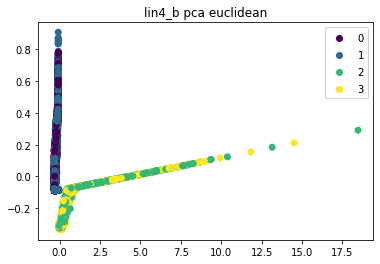

In [45]:
viz_plot_grad(grdic_te,z_te+2*y_te,lywise=True, param_names=param_names)

In [47]:
from sklearn.metrics.pairwise import cosine_similarity
def corr_grad(grad_arr,y,z):
    mgrad = np.mean(grad_arr,axis=0)
    mgrad_y0 = np.mean(grad_arr[y==0],axis=0)
    mgrad_y1 = np.mean(grad_arr[y==1],axis=0)
    mgrad_z0 = np.mean(grad_arr[z==0],axis=0)
    mgrad_z1 = np.mean(grad_arr[z==1],axis=0)
    aa = [mgrad,mgrad_y0,mgrad_y1,mgrad_z0,mgrad_z1]
    for a in aa:
        print(np.linalg.norm(a))
    aan = np.row_stack(aa)
    print(cosine_similarity(aan,aan))

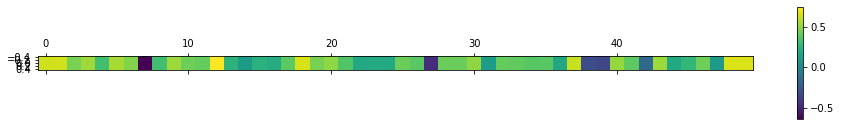

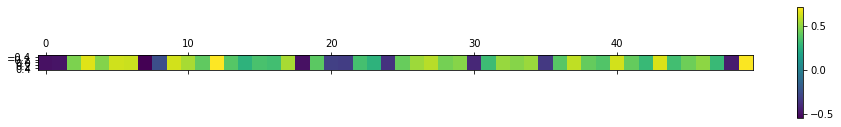

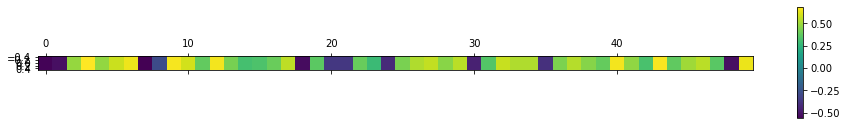

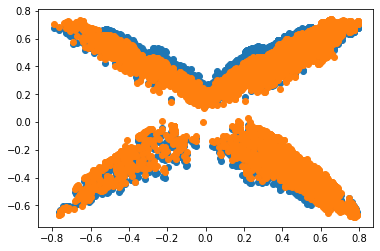

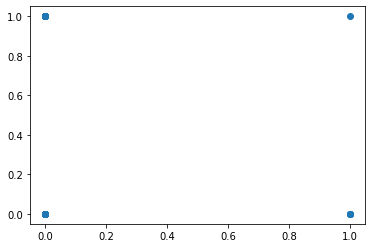

In [70]:
st_idx = 0
ds_idx = 50
sim_mat = cosine_similarity(np.expand_dims(np.mean(wgrad_te,axis=0),axis=0), wgrad_te)
plt.matshow(sim_mat[st_idx:ds_idx,st_idx:ds_idx])
plt.colorbar()
plt.show()
sim_mat2 = cosine_similarity(np.expand_dims(np.mean(wgrad_te2,axis=0),axis=0), wgrad_te2)
plt.matshow(sim_mat2[st_idx:ds_idx,st_idx:ds_idx])
plt.colorbar()
plt.show()
sim_mat3 = cosine_similarity(np.expand_dims(np.mean(wgrad_te3,axis=0),axis=0), wgrad_te3)
plt.matshow(sim_mat3[st_idx:ds_idx,st_idx:ds_idx])
plt.colorbar()
plt.show()
plt.scatter(sim_mat,sim_mat3)
plt.scatter(sim_mat,sim_mat2)
plt.show()
plt.scatter(y_tr[st_idx:ds_idx],out_tr[st_idx:ds_idx])
plt.show()

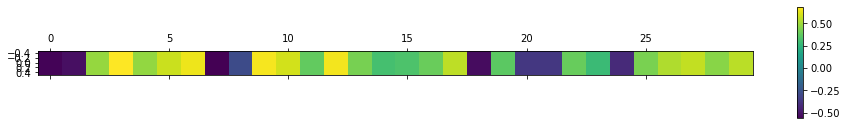

In [149]:
wgrad_tr.shape

(5000, 3617)

In [55]:
ngr = np.linalg.norm(wgrad_tr,axis=1)
ngr2 = np.linalg.norm(wgrad_tr2,axis=1)
ngr3 = np.linalg.norm(wgrad_tr3,axis=1)

In [56]:
ngrte = np.linalg.norm(wgrad_te,axis=1)
ngr2te = np.linalg.norm(wgrad_te2,axis=1)
ngr3te = np.linalg.norm(wgrad_te3,axis=1)

In [155]:
ngr.shape

(5000,)

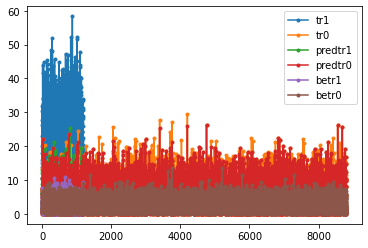

In [61]:
plt.plot(ngr[y_tr==1],marker='.',label='tr1')
plt.plot(ngr[y_tr==0],marker='.',label='tr0')
plt.plot(ngr2[y_tr==1],marker='.',label='predtr1')
plt.plot(ngr2[y_tr==0],marker='.',label='predtr0')
plt.plot(ngr3[y_tr==1],marker='.',label='betr1')
plt.plot(ngr3[y_tr==0],marker='.',label='betr0')
plt.legend()
plt.show()

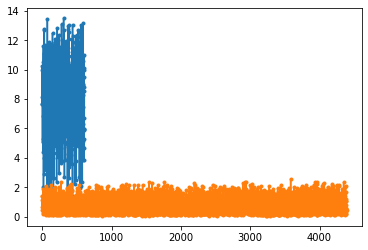

In [164]:
plt.plot(ngr[y_tr==1],marker='.')
plt.plot(ngr[y_tr==0],marker='.')
# plt.plot(ngr2[y_tr==1],marker='.')
# plt.plot(ngr2[y_tr==0],marker='.')
plt.show()

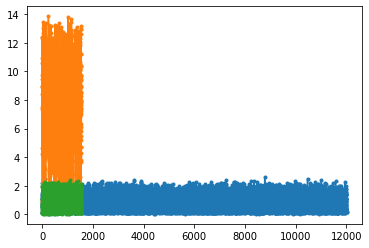

In [171]:
plt.plot(ngrte[y_te==0],marker='.')
plt.plot(ngrte[y_te==1],marker='.')
plt.plot(ngr2te[y_te==1],marker='.')
# plt.plot(ngr2te[y_te==0],marker='.')
plt.show()

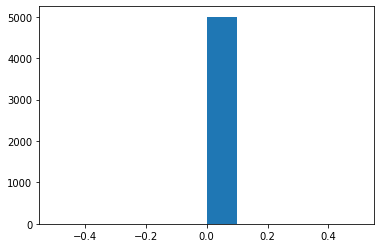

In [147]:
plt.hist(out_tr)
plt.show()

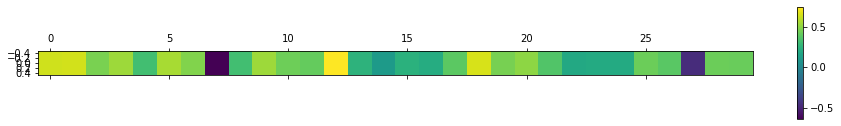

In [137]:
for i in range(30):
    print("-"*10,i,'-'*10)
    print(out_te[i],out_te2[i])
    print(y_te[i],y_te2[i])

---------- 0 ----------
0.0 0.0
0.0 0.0
---------- 1 ----------
0.0 0.0
0.0 0.0
---------- 2 ----------
0.0 0.0
0.0 0.0
---------- 3 ----------
0.0 0.0
0.0 0.0
---------- 4 ----------
0.0 0.0
0.0 0.0
---------- 5 ----------
0.0 0.0
0.0 0.0
---------- 6 ----------
0.0 0.0
0.0 0.0
---------- 7 ----------
0.0 0.0
0.0 0.0
---------- 8 ----------
0.0 0.0
0.0 0.0
---------- 9 ----------
0.0 0.0
1.0 1.0
---------- 10 ----------
0.0 0.0
0.0 0.0
---------- 11 ----------
0.0 0.0
0.0 0.0
---------- 12 ----------
0.0 0.0
0.0 0.0
---------- 13 ----------
0.0 0.0
0.0 0.0
---------- 14 ----------
0.0 0.0
0.0 0.0
---------- 15 ----------
0.0 0.0
0.0 0.0
---------- 16 ----------
0.0 0.0
0.0 0.0
---------- 17 ----------
0.0 0.0
0.0 0.0
---------- 18 ----------
0.0 0.0
0.0 0.0
---------- 19 ----------
0.0 0.0
0.0 0.0
---------- 20 ----------
0.0 0.0
0.0 0.0
---------- 21 ----------
0.0 0.0
1.0 1.0
---------- 22 ----------
0.0 0.0
0.0 0.0
---------- 23 ----------
0.0 0.0
1.0 1.0
---------- 24 ----------
0

In [124]:
sim_mat[20]

array([-0.43377766, -0.6402937 , -0.6737147 , ..., -0.40176624,
       -0.42649603, -0.49073365], dtype=float32)

In [99]:
corr_grad(wgrad_tr,y_tr,z_tr)
corr_grad(grdic_tr[param_names[-2]],y_tr,z_tr)

0.5823407
0.5773308
0.63085115
0.6084997
0.56581306
[[1.         0.9997345  0.9865428  0.998702   0.99933374]
 [0.9997345  1.         0.9825118  0.99805975 0.9993384 ]
 [0.9865428  0.9825118  1.0000001  0.9879358  0.98396915]
 [0.998702   0.99805975 0.9879358  0.99999976 0.9961771 ]
 [0.99933374 0.9993384  0.98396915 0.9961771  0.99999994]]
0.08172918
0.079997815
0.09518993
0.085789286
0.07902379
[[1.         0.9999912  0.99962527 0.99999875 0.99999934]
 [0.9999912  1.         0.9995017  0.9999849  0.99999416]
 [0.99962527 0.9995017  0.99999994 0.999657   0.99960107]
 [0.99999875 0.9999849  0.999657   1.0000002  0.9999961 ]
 [0.99999934 0.99999416 0.99960107 0.9999961  1.        ]]


In [95]:
corr_grad(wgrad_tr,y_tr,z_tr)
corr_grad(grdic_tr[param_names[-2]],y_tr,z_tr)

0.21170019
0.5773308
5.756207
0.29312932
0.16806728
[[ 1.0000006  -0.5836741   0.77558863  0.9748996   0.96594393]
 [-0.5836741   1.         -0.9652493  -0.723652   -0.3840909 ]
 [ 0.77558863 -0.9652493   1.0000001   0.87632877  0.6094719 ]
 [ 0.9748996  -0.723652    0.87632877  0.99999976  0.8840878 ]
 [ 0.96594393 -0.3840909   0.6094719   0.8840878   1.0000005 ]]
0.008668817
0.079997815
0.6956734
0.019706475
0.0014876949
[[ 0.9999998  -0.9963359   0.9970901   0.9987172   0.89456725]
 [-0.9963359   1.         -0.9999564  -0.9992748  -0.85406816]
 [ 0.9970901  -0.9999564   0.9999999   0.99956965  0.8587885 ]
 [ 0.9987172  -0.9992748   0.99956965  1.          0.8707893 ]
 [ 0.89456725 -0.85406816  0.8587885   0.8707893   1.        ]]


In [163]:
wgrad_arr = np.array(torch.cat(wgrad_list,dim=0).numpy(),dtype=np.float32)

In [164]:
wmean = np.mean(wgrad_arr,axis=0)
wmean_y0 = np.mean(wgrad_arr[y_arr==0],axis=0)
wmean_y1 = np.mean(wgrad_arr[y_arr==1],axis=0)

wmean_z0 = np.mean(wgrad_arr[z_arr==0],axis=0)
wmean_z1 = np.mean(wgrad_arr[z_arr==1],axis=0)

In [165]:
aa = [wmean,wmean_y0,wmean_y1,wmean_z0,wmean_z1]
for a in aa:
    print(np.linalg.norm(a))

0.13962102
4.8208594
1.0861616
0.21773386
0.09296312


In [170]:
from sklearn.metrics.pairwise import cosine_similarity
aan = np.row_stack(aa)
print(cosine_similarity(aan,aan))

[[ 1.0000001   0.671366   -0.57849014  0.96020055  0.5429791 ]
 [ 0.671366    1.0000004  -0.992907    0.8454311  -0.23911381]
 [-0.57849014 -0.992907    0.9999998  -0.7764525   0.3502759 ]
 [ 0.96020055  0.8454311  -0.7764525   1.0000006   0.2868148 ]
 [ 0.5429791  -0.23911381  0.3502759   0.2868148   0.9999997 ]]


In [71]:
calculate_overall_accuracy(out_tr,y_tr)

0.7364

In [72]:
calculate_overall_accuracy(out_tr[z_tr==0],y_tr[z_tr==0])

0.7331341797361215

In [73]:
calculate_overall_accuracy(out_tr[z_tr==1],y_tr[z_tr==1])

0.7385926792578974

In [132]:
def calculate_overall_accuracy(pred,y):
    pred = pred.flatten()
    return np.sum(pred==y)/len(pred)

In [177]:
gdl_arr = torch.cat(grad_dic['lin4_w'],dim=0).numpy()
print(gdl_arr.shape)

(10000, 32)


In [178]:
lmean = np.mean(gdl_arr,axis=0)
lmean_y0 = np.mean(gdl_arr[y_arr==0],axis=0)
lmean_y1 = np.mean(gdl_arr[y_arr==1],axis=0)

lmean_z0 = np.mean(gdl_arr[z_arr==0],axis=0)
lmean_z1 = np.mean(gdl_arr[z_arr==1],axis=0)

In [179]:
from sklearn.metrics.pairwise import cosine_similarity
aal = [lmean,lmean_y0,lmean_y1,lmean_z0,lmean_z1]
for a in aal:
    print(np.linalg.norm(a))

aanl = np.row_stack(aal)
print(cosine_similarity(aanl,aanl))

0.0093537625
0.5467532
0.12926793
0.016414464
0.010477241
[[ 1.          0.5711562  -0.5087406   0.87814206  0.27278316]
 [ 0.5711562   1.         -0.99724925  0.8935682  -0.63254535]
 [-0.5087406  -0.99724925  1.0000002  -0.85789883  0.68806326]
 [ 0.87814206  0.8935682  -0.85789883  0.99999994 -0.22071445]
 [ 0.27278316 -0.63254535  0.68806326 -0.22071445  1.        ]]


In [182]:
type(grad_dic) == dict

True

In [71]:
y_arr2.shape

(13564,)

## visualize

In [171]:
from sklearn.manifold import TSNE

In [172]:
from sklearn.decomposition import PCA

def viz_plot_grad(grad_list, c_idx = None,method='pca',lywise=False,metric='euclidean',param_names = None):
    if lywise:
        print("lywise")
        assert param_names is not None
        for i, pn in enumerate(param_names):
#             print(grad_list[pn])
            grad_arr = np.array(torch.cat(grad_list[pn],dim=0).numpy(),dtype=np.float32)
            draw_plot(grad_arr,c_idx,method,metric,title=pn)
    else:
        grad_arr = np.array(torch.cat(grad_list,dim=0).numpy(),dtype=np.float32)
#         print(grad_arr.shape)
        draw_plot(grad_arr,c_idx,method,metric)

def draw_plot(grad_arr, c_idx, method,metric = 'euclidean',title =None):
    assert method in ['pca','tsne']
    if method == 'pca':
        grad_emb = PCA(n_components=2,whiten=False).fit_transform(grad_arr)
    else:
        grad_emb = TSNE(n_components=2,learning_rate='auto',init = 'random',metric=metric).fit_transform(grad_arr)
    fig,ax = plt.subplots()
    scatter = ax.scatter(grad_emb[:,0],grad_emb[:,1],c=c_idx)
    legend1 = ax.legend(*scatter.legend_elements())
    ax.add_artist(legend1)
    if title is not None:
        plt.title(title)
    plt.show()

In [105]:
len(wgrad_list)

157

(10000, 3617)


/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


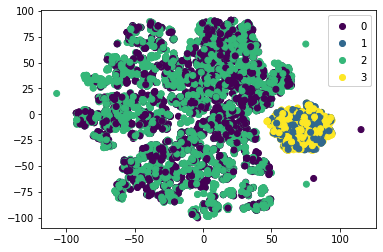

In [111]:
viz_plot_grad(wgrad_list,y_arr+2*z_arr,method='tsne',metric='cosine')

(13564, 3617)


/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


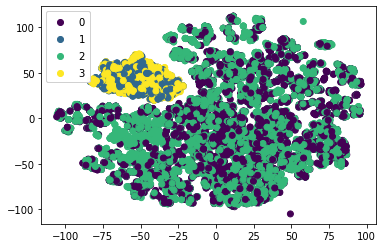

In [112]:
viz_plot_grad(wgrad_list2,y_arr2+2*z_arr2,method='tsne',metric='cosine')

(10000, 3617)


/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


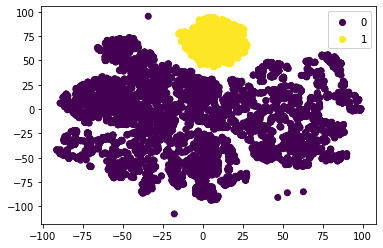

In [109]:
viz_plot_grad(wgrad_list,y_arr,method='tsne',metric='cosine')

(10000, 3617)


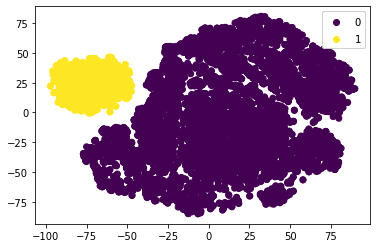

In [107]:
viz_plot_grad(wgrad_list,y_arr,method='tsne')

lywise


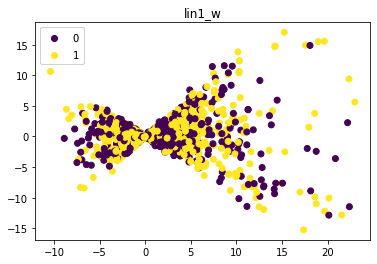

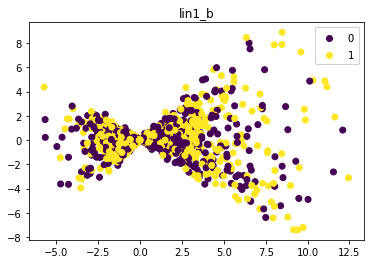

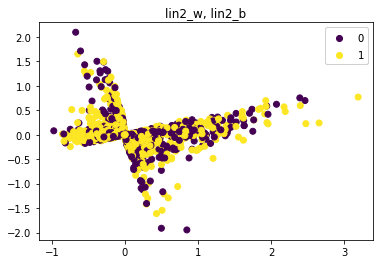

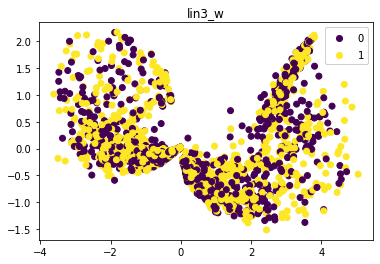

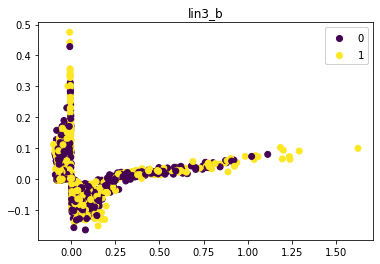

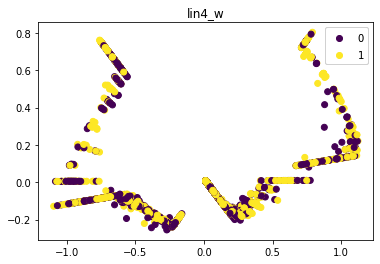

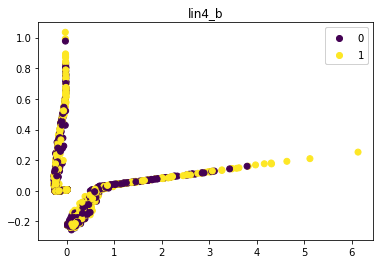

In [95]:
viz_plot_grad(grad_dic,z_arr,lywise=True,param_names =param_names)

lywise


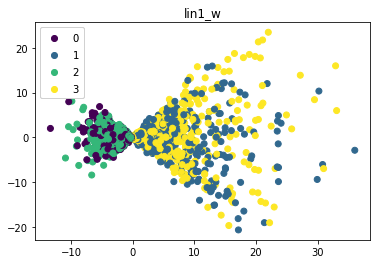

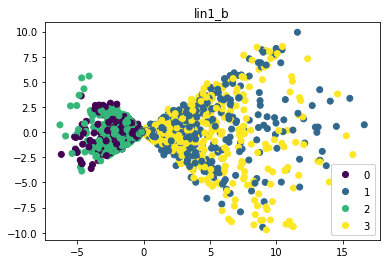

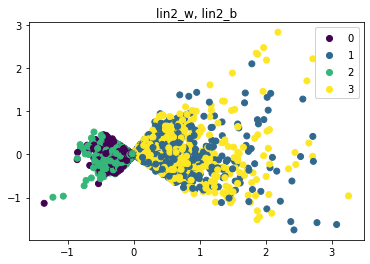

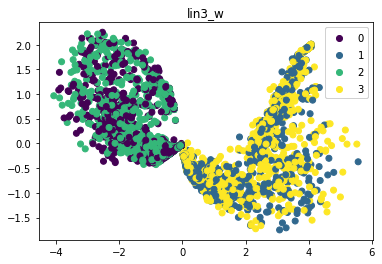

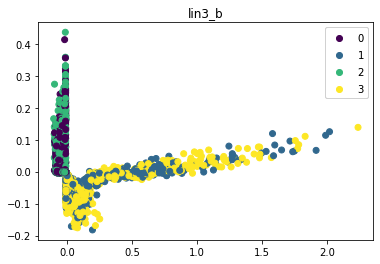

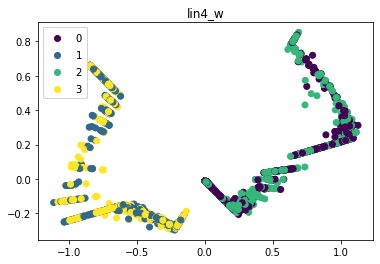

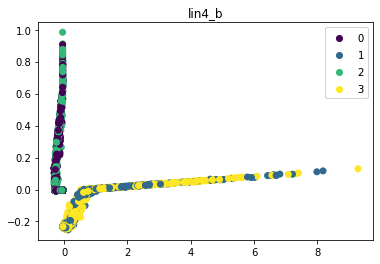

In [113]:
viz_plot_grad(grad_dic2,y_arr2+2*z_arr2,lywise=True,param_names =param_names)

lywise


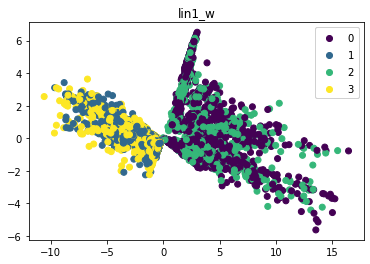

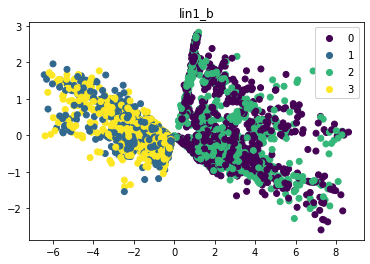

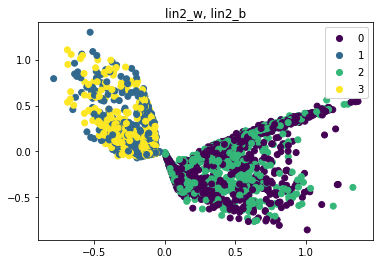

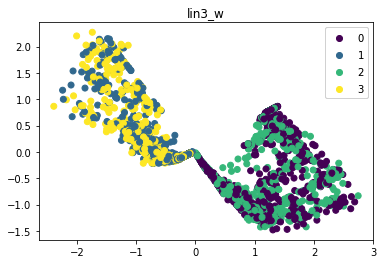

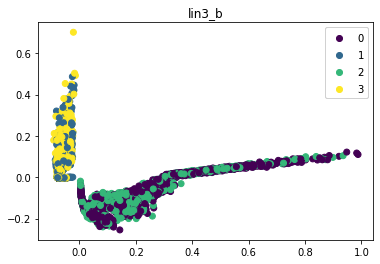

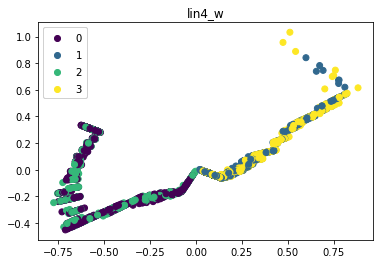

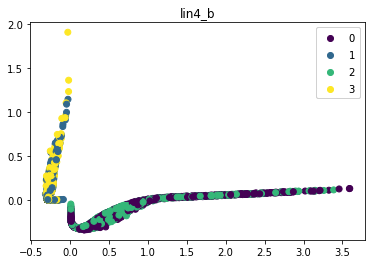

In [174]:
viz_plot_grad(grad_dic,y_arr+2*z_arr,lywise=True,param_names =param_names)